In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import h5py

# Define parameters
image_size = (150, 150)
batch_size = 32
num_epochs = 30
train_data_dir = '/content/drive/MyDrive/plantdisease/train_leaf'
test_data_dir = '/content/drive/MyDrive/plantdisease/test_leaf'

# Enhanced Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3
)

# Rescale the pixel values for the test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load training data with a maximum of 30 photos per class
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42,
    interpolation='nearest'
)

# Load test data with a maximum of 30 photos per class
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    interpolation='nearest'
)

# Use InceptionV3 as a base model with transfer learning
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add custom head for classification with an additional Dense layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Additional Dense layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model except the added layers
for layer in base_model.layers:
    layer.trainable = False

# Use a different learning rate scheduler for better convergence
def schedule(epoch, learning_rate):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(schedule)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the enhanced configuration
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[lr_scheduler]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Save the trained model in the native Keras format
model.save("crop_disease.keras")

Found 140 images belonging to 14 classes.
Found 70 images belonging to 14 classes.
87910968/87910968 [==============================] - 4s 0us/step


Epoch 1/30
4/4 [==============================] - 139s 43s/step - loss: 3.5627 - accuracy: 0.0938 - val_loss: 2.3306 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 2/30
4/4 [==============================] - 14s 4s/step - loss: 3.3038 - accuracy: 0.2130 - val_loss: 2.1359 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 3/30
4/4 [==============================] - 10s 3s/step - loss: 2.7968 - accuracy: 0.2222 - val_loss: 1.8708 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 4/30
4/4 [==============================] - 9s 2s/step - loss: 2.7205 - accuracy: 0.2500 - val_loss: 1.6011 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/30
4/4 [==============================] - 13s 4s/step - loss: 2.4398 - accuracy: 0.3241 - val_loss: 1.6943 - val_accuracy: 0.4844 - lr: 0.0010
Epoch 6/30
4/4 [==============================] - 13s 3s/step - loss: 2.0011 - accuracy: 0.4074 - val_loss: 1.6538 - val_accuracy: 0.4844 - lr: 0.0010
Epoch 7/30
4/4 [==============================] - 10s 3s/step - loss: 2.0150 - accuracy: 0.39

1/1 [==============================] - 2s 2s/step
Predicted Class: strawberry_healthy
Probability: 0.9167


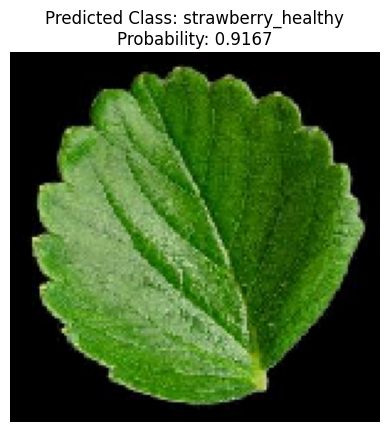

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt  # Add Matplotlib for image display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Define parameters
image_size = (150, 150)
model_path = '/content/crop_disease.keras'

# Load the trained model
model = load_model(model_path)

# Function to predict if an image contains a brain tumor or not
def predict_crop_disease(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=image_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Rescale the pixel values

    # Make predictions
    prediction = model.predict(img)

    # Use the class indices from the training generator
    class_labels = list(train_generator.class_indices.keys())

    # Get the predicted class label and probability
    predicted_class = class_labels[np.argmax(prediction)]
    probability = prediction[0][np.argmax(prediction)]

    return predicted_class, probability, img

# Example usage:
image_path = '/content/drive/MyDrive/plantdisease/test_leaf/strawberry_healthy/sh1.jpg'
predicted_class, probability, img = predict_crop_disease(image_path)

print(f'Predicted Class: {predicted_class}\nProbability: {probability:.4f}')
# Display the input image
plt.imshow(img[0])
plt.title(f'Predicted Class: {predicted_class}\nProbability: {probability:.4f}')
plt.axis('off')
plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 250 images belonging to 25 classes.
Found 125 images belonging to 25 classes.


Epoch 1/30
7/7 [==============================] - 55s 8s/step - loss: 3.9186 - accuracy: 0.0734 - val_loss: 2.7114 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - 18s 3s/step - loss: 3.2042 - accuracy: 0.1881 - val_loss: 2.1247 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - 17s 2s/step - loss: 2.3948 - accuracy: 0.3349 - val_loss: 1.8367 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 4/30
7/7 [==============================] - 22s 3s/step - loss: 2.1848 - accuracy: 0.4330 - val_loss: 1.8239 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 5/30
7/7 [==============================] - 18s 3s/step - loss: 1.9217 - accuracy: 0.4241 - val_loss: 1.5187 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 6/30
7/7 [==============================] - 22s 3s/step - loss: 1.6589 - accuracy: 0.5268 - val_loss: 1.5371 - val_accuracy: 0.6354 - lr: 1.0000e-04
Epoch 7/30
7/7 [==============================] - 18s 3s/step - loss: 1.7576 - accuracy: 0